In [1]:
# IMPORTS
import os 
import sys
import numpy as np
import random


# PYTORCH
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torch.multiprocessing.set_sharing_strategy('file_system')

# GANOCRACY LIB
sys.path.append('../')
import ganocracy
from ganocracy.data import datasets as dset
from ganocracy.data import transforms
from ganocracy import metrics, models
from ganocracy.models import utils as mutils
from ganocracy.utils import visualizer as vutils

# NOTEBOOK-SPECIFIC IMPORTS
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Video
import moviepy.editor as mpy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
    
# Set random seem for reproducibility.
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Use this command to make a subset of GPUs
# visible to the jupyter notebook.
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'

Random Seed:  999


In [ ]:

dataroot = "data"            # Root directory for dataset
dataset_name = 'BuildingsHQ' # Name of dataset.
dataset_type = 'ImageHDF5'   # Type/format of dataset. Choices: ['ImageFolder', 'ImageHDF5']

# Use standard number of classes
# for chosen of dataset.
n_classes = {
    'CelebA': 1,
    'CIFAR10': 10,
    'CIFAR100': 100,
    'ImageNet': 1000,
}.get(dataset_name, 1)


split = 'train' # Dataset split (train or val), if applicable.

num_workers = 12 # Number of workers for dataloader
batch_size = 256 # Batch size per forward/backward pass.
download = True # If data is not found, download and cache it.

load_in_mem = False # Load entire dataset into RAM.

# Spatial size of training images. All images will be resized to this
# size using a transformer.
resolution = 128

# Number of channels in the training images. For color images this is 3
nc = 3

dim_z = 100 # Size of z latent vector (i.e. size of generator input)


G_ch = 64 # Size of feature maps in G and D.
D_ch = 64

num_epochs = 200 # Number of training epochs

G_lr = 2e-4      # Learning rate for optimizers
D_lr = 2e-4

num_D_steps = 1
num_D_accumulations = 1
num_G_accumulations = 1
use_ema = True

D_batch_size = batch_size * num_D_steps * num_D_accumulations

# Betas hyperparams for Adam optimizers
G_betas = (0.5, 0.999)
D_betas = (0.5, 0.999)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 3

test_every = 500
sample_every = 100

name = 'dev_ema_cDCGAN'
model_dir = 'checkpoints'
samples_dir = 'samples'

TRAIN = True
RESUME = False
LOAD_PRETRAINED = False

model_name = '_'.join(map(str, [
    name,
    dataset_name, 
    resolution,
    'bs{}'.format(batch_size),
    'dim_z{}'.format(dim_z),
    'G_ch{}'.format(G_ch),
    'D_ch{}'.format(D_ch),
    'G_lr{}'.format(G_lr),
    'D_lr{}'.format(D_lr),
    'G_betas{}'.format('_'.join(map(str, G_betas))),
    'D_betas{}'.format('_'.join(map(str, D_betas))),
]))

dataset_dir = os.path.join(dataroot, dataset_name)
save_name = os.path.join(model_dir, model_name + '.pth.tar')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(os.path.join(samples_dir, model_name), exist_ok=True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(f'Starting experiment {model_name}')

In [3]:
# Create torch.utils.data.Dataset.
dataset = dset.get_dataset(dataset_name,
                           root_dir=dataroot,
                           resolution=resolution,
                           dataset_type=dataset_type,
                           download=download, split=split,
                           load_in_mem=load_in_mem)
# Create the dataloader.
dataloader = torch.utils.data.DataLoader(dataset, 
                                         shuffle=True,
                                         batch_size=D_batch_size,
                                         num_workers=num_workers)
vutils.visualize_data(dataloader)

Dataset ImageHDF5
    Number of classes: 26
    Number of datapoints: 1018308
    HDF5 File: data/BuildingsHQ-128.hdf5
    Transforms (if any): <function hdf5_transform at 0x7f4d90616ea0>
    Target Transforms (if any): <function get_dataset.<locals>.target_transform at 0x7f4e585401e0>


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Using your own data

If you would like to train a GAN on a your own custom dataset, subclassing [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is a sensible approach as it allows you to make use of PyTorch's dataloading utilities, including the multi-threaded DataLoader and transforms from above.

If your training data consist of image files, the [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class facilitates easy dataloading. Simply arrange your files in the following way:

    root/dogball/xxx.png
    root/dogball/xxy.png
    root/dogball/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png
    
where each subdirectory of `root` is considered an image category containing examples of that category. Then, just change the configuration so that make sure you set 
`dataset_name -> Custom`, `dataset_type -> ImageFolder` with `data_root`

### Prepare data as single HDF5 file (optional, for additional performance)

If your dataset consists of large, high-resolution images, then repeatedly applying transforms to the raw images (cropping, resizing) results in many wasted CPU cycles. Furthermore, increasing your batchsize puts additional I/O strain on your filesystem. Together, these factors may produce a dataloading bottleneck where your GPUs consume data faster than your system can produce it. To remedy this, you may choose to prepare a pre-processed HDF5 version of your target dataset using the utilities provided. Moreover, if I/O still appears to be the bottleneck, you may choose to load the entire dataset into RAM by setting `load_in_mem` dataset kwargs to `True` (if your system can support this).

Another advantage to using a single, preprocessed HDF5 is the ease with which you can transfer data to multiple remote machines, which normally becomes cumbersome and time consuming when attempting large, distributed experiments.

### Preparing to measure sample quality during training

Typically, when training any sort of neural network, it is standard practice to monitor the value of the objective function (loss) throughout the course of the experiment. With GANs, it is also common to break the loss into individual components. However, the adversarial losses measure the competition between the generator and discriminator and do not necessarily reflect the image quality of generated samples. Without an objective measure of image quality, comparing models, monitoring progress and tuning models is near impossible.

In the early day of GAN research, samples were compared visually, which obviously has several issues (ratings could be highly subjective and biases, and evaluating at scale is difficult). On the other hand, objectively evaluating implicit generative models still remains difficult and an active area of investigation. Despite their notable flaws, researchers have recently settled on two popular metrics, which aim to capture image quality and diversity:

- **Inception Score (IS):** Score based on how confidently an ImageNet-pretrained InceptionV3 network can classify generated samples and the diversity of its predictions over large collection of samples. If a model produces samples that InceptionV3 can confidently classify, this contributes to a higher IS. A high diversity of classifications also contributes to a higher IS. 

- **Fréchet Distance (FID):** Measures the distance between two distributions. Here, an Inception Network is used to generate feature representations for both the real images from the dataset of interest and generated samples from the model. These feature distributions are model by multivariate Guassian distributions. The shorter the FréchetDistance between these two distributions, the more closely the fake images resemble the real ones. 

Summary

- Higher IS values mean better image quality and diversity (usually).
- Lower FID values mean better image quality and diversity.

#### Some Caveats
Since the InceptionV3 model is trained to classify ImageNet categories, Inception Score can be a very poor measure of quality on datasets other than ImageNet, although not completely uninformative. While the absolute scale of non-ImageNet based datasets might be lower (and not comparable), relative changes in inception score generally still correlate with image quality. An alternative, although not standardized, practice would be to train an Inception Classifier on the datset of interest, and use that trained network to compute inception scores instead.

In [4]:
inception_moments_file = metrics.calculate_inception_moments(dataloader, dataroot, dataset_name)

def test(G, batch_size, dim_z, n_classes, num_inception_images=5000, num_splits=10):
    def sample():
        with torch.no_grad():
            z = torch.randn(batch_size, dim_z, device=device)
            y = torch.randint(n_classes, (batch_size,), device=device)
            G_z = G(z, y)
        return G_z, y
    
    # Load pretrained inception network.
    net = metrics.load_inception_net()
    
    # Load precomputed
    data = np.load(inception_moments_file)
    data_mu, data_sigma = data['mu'], data['sigma']
    
    # Accumulate `num_inception_images` inception features and logits.
    pool, logits, labels = metrics.accumulate_inception_activations(sample, net, num_inception_images)
    
    # Compute inception score mean/std from logits averaged over `num_split` splits.
    IS_mean, IS_std = metrics.calculate_inception_score(logits.cpu().numpy(), num_splits)
    
    # Compute mean and covariance of extracted inception features from generated samples.
    mu, sigma = torch.mean(pool, 0), metrics.torch_cov(pool, rowvar=False)
    FID = metrics.torch_calculate_frechet_distance(mu, sigma,
                                                   torch.tensor(data_mu).float().to(mu.device),
                                                   torch.tensor(data_sigma).float().to(sigma.device))    
    return IS_mean, FID

data/BuildingsHQ_inception_moments.npz found!


Initializing EMA parameters to be source parameters...
ConditionalGenerator(
  (shared): Embedding(1, 128)
  (linear): Linear(in_features=100, out_features=16384, bias=True)
  (GBlocks): ModuleList(
    (0): GBlock(
      (conv): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(1024, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): SNLinear(in_features=128, out_features=1024, bias=False)
        (beta_embed): SNLinear(in_features=128, out_features=1024, bias=False)
      )
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(512, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): SNLinear(in_features=128, out_features=512, bias=False)
        (bet

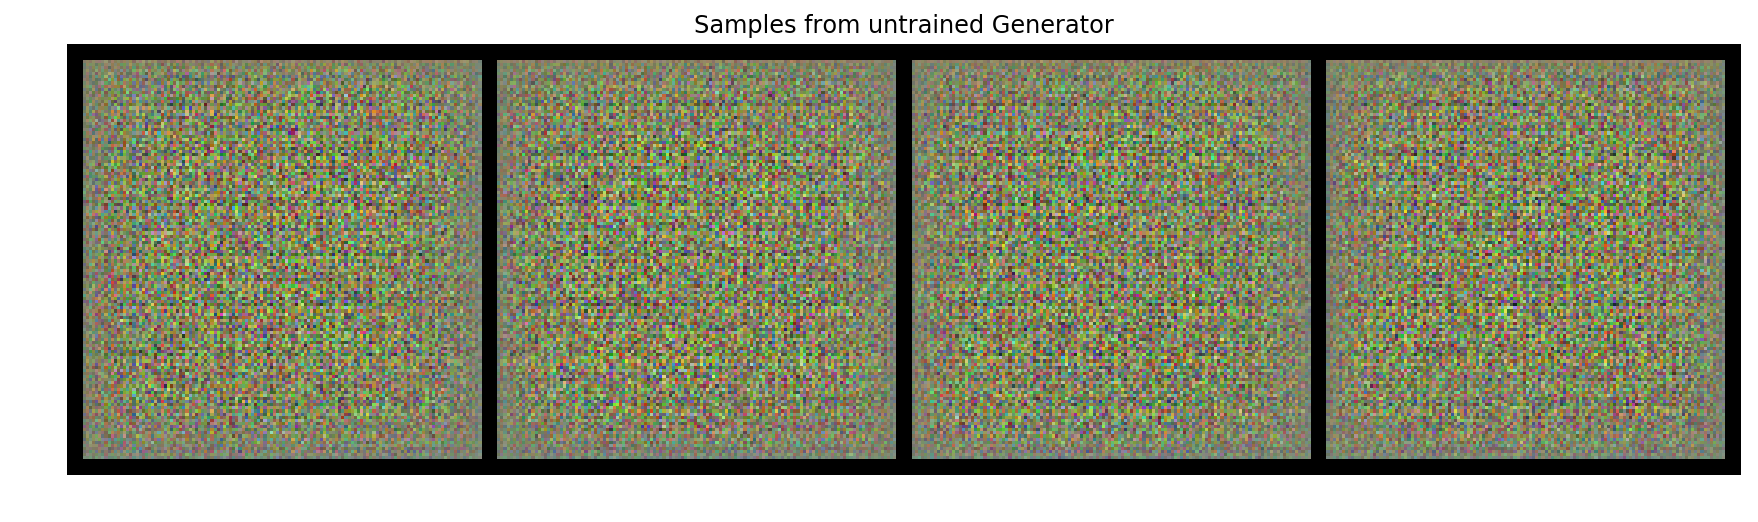

In [5]:
# Instantiate DCGAN Generator instance.
# TODO: Add appropriate args, plus option to download pretrained model.
G = models.dcgan.ConditionalGenerator(dim_z=dim_z,
                                      n_classes=n_classes,
                                      resolution=resolution).to(device)
if use_ema:
    ema = mutils.EMA(G)
    G_ema = ema.target
print(G)  # View model architecture.

# Create some input tensors.
z = torch.randn(4, G.dim_z).to(device)
y = torch.randint(G.n_classes, (4,)).to(device)

# Generate samples while capturing the sizes of intermediate outputs.
output, names, sizes = mutils.hook_sizes(G, inputs=(z, y), verbose=True)
vutils.visualize_samples(output, title='Samples from untrained Generator')

In [6]:
# Create the Discriminator
D = models.dcgan.Discriminator(resolution=resolution).to(device)
 

    

print(D)

Discriminator(
  (input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (DBlocks): Sequential(
    (0): DBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): DBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): DBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): DBloc

In [ ]:
# Handle multi-gpu if desired.
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
    D = nn.DataParallel(D, list(range(ngpu)))
    
# Initialize BCELoss function.
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, dim_z, device=device)
fixed_labels = torch.randint(n_classes, (batch_size, ), device=device)


# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

if LOAD_PRETRAINED:
    state_dict = torch.load(save_name)
    G.load_state_dict(state_dict['G'])
    D.load_state_dict(state_dict['D'])

# Setup Adam optimizers for both G and D
G_optim = optim.Adam(G.parameters(), lr=G_lr, betas=G_betas)
D_optim = optim.Adam(D.parameters(), lr=D_lr, betas=D_betas)

In [ ]:
if RESUME:
    pass
    
#     TODO
else:
    img_list = []
    G_losses = []
    D_losses = []
    IS_scores = []
    FIDs = []
    iters = 0
    best_IS = 0
    best_FID = 9999

# Training Loop
if TRAIN:

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            
            counter = 0
            data = [d.to(device) for d in data]
            x, y = [torch.split(d, batch_size) for d in data]
            
            real_labels = torch.full((batch_size,), real_label, device=device)
            fake_labels = torch.full((batch_size,), fake_label, device=device) 
            
            #################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            #################################################################

            D.zero_grad()            
            for step_index in range(num_D_steps):
                D.zero_grad()
                for accumulation_index in range(num_D_accumulations):
                    
                    ################## ** Train with all-real batch ** ##

                    # Forward pass real batch through D
                    output = D(x[counter]).view(-1)
                    
                    # Calculate loss on all-real batch
                    D_loss_real = criterion(output, real_labels[:output.size(0)]) / float(num_D_accumulations)
                    D_loss_real.backward()
                    D_x = output.mean().item()

                    ## ** Train with all-fake batch ** ##
                
                    # Generate batch of latent vectors and targets
                    noise = torch.randn(batch_size, dim_z, device=device)
                    targets = torch.randint(n_classes, (batch_size,), device=device)
                    
                    # Generate fake image batch with G
                    fake_image = G(noise, targets)

                    # Classify all fake batch with D
                    output = D(fake_image.detach()).view(-1)

                    # Calculate D's loss on the all-fake batch
                    D_loss_fake = criterion(output, fake_labels[:output.size(0)]) / float(num_D_accumulations)
                    D_loss_fake.backward()
                    D_G_z1 = output.mean().item()
                    
                    # Add the gradients from the all-real and all-fake batches
#                     D_loss = (D_loss_real + D_loss_fake) / float(num_D_accumulations)
                    D_loss = (D_loss_real + D_loss_fake)
                    counter += 1
                    
                # Update D
                D_optim.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            
            G.zero_grad()
            for accumulation_index in range(num_G_accumulations):
                
                # Generate batch of latent vectors and targets
                noise = torch.randn(batch_size, dim_z, device=device)
                targets = torch.randint(n_classes, (batch_size,), device=device)
                
                fake_image = G(noise, targets)
                output = D(fake_image).view(-1)
                
                # Calculate G's loss based on this output
                G_loss = criterion(output, real_labels) / float(num_G_accumulations)
                    
                # Calculate gradients for G
                G_loss.backward()
                D_G_z2 = output.mean().item()
                
            # Update G
            G_optim.step()
            
            if use_ema:
                ema.update(iters)

            # Output training stats
            if i % 10 == 0:
                print('[{}/{}][{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f} / {:.4f}'.
                     format(epoch, num_epochs, i, len(dataloader),
                            D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
#                 print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                       % (epoch, num_epochs, i, len(dataloader),
#                          D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % sample_every == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    if use_ema:
                        fake_image = G_ema(fixed_noise, fixed_labels).detach().cpu()
                    else:
                        fake_image = G(fixed_noise, fixed_labels).detach().cpu()
                fname = os.path.join(samples_dir, model_name, f'{iters:06d}.jpg')
                torchvision.utils.save_image(fake_image, fname, padding=2, normalize=True )
                img_list.append(torchvision.utils.make_grid(fake_image, padding=2, normalize=True))
                
            if (iters % test_every == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    IS, FID = test(G_ema if use_ema else G, batch_size, dim_z, n_classes)
                print('Itr {}: PYTORCH Inception Score is {:3.3f} '
                      'PYTORCH FID is {:5.4f}'.format(iters, IS, FID))
                IS_scores.append(IS)
                FIDs.append(FID)
                # Remember best IS and FID and save checkpoint.
                is_best_IS = IS > best_IS
                is_best_FID = FID < best_FID
                best_IS = max(IS, best_IS)
                best_FID = min(FID, best_FID)

                mutils.save_checkpoint({
                    'G': G.state_dict(),
                    'G_ema': G_ema.state_dict() if use_ema else None,
                    'D': D.state_dict(),
                    'G_optim': G_optim.state_dict(),
                    'D_optim': D_optim.state_dict(),
                    'resolution': resolution,
                    'batch_size': batch_size,
                    'G_ch': G_ch,
                    'D_ch': D_ch,
                    'G_lr': G_lr,
                    'D_lr': D_lr,
                    'G_betas': G_betas,
                    'D_betas': D_betas,
                    'iters': iters,
                    'epoch': epoch,
                    'IS_scores': IS_scores,
                    'FIDs': FIDs,
                    'best_IS': best_IS,
                    'best_FID': best_FID,
                }, is_best_IS, is_best_FID, 
                    filename=save_name)
                    
            iters += 1

Starting Training Loop...
[0/200][0/3978]	Loss_D: 1.4681	Loss_G: 3.1649	D(x): 0.4972	D(G(z)): 0.5318 / 0.0444
Itr 0: PYTORCH UNOFFICIAL Inception Score is 1.371 PYTORCH UNOFFICIAL FID is 395.0027
[0/200][10/3978]	Loss_D: 1.6772	Loss_G: 4.4746	D(x): 0.4521	D(G(z)): 0.5375 / 0.0134
[0/200][20/3978]	Loss_D: 2.1518	Loss_G: 3.8207	D(x): 0.5485	D(G(z)): 0.7651 / 0.0352
[0/200][30/3978]	Loss_D: 2.8388	Loss_G: 3.2523	D(x): 0.5685	D(G(z)): 0.8507 / 0.0755
[0/200][40/3978]	Loss_D: 1.1732	Loss_G: 1.7277	D(x): 0.5926	D(G(z)): 0.4295 / 0.2048
[0/200][50/3978]	Loss_D: 1.2867	Loss_G: 1.0930	D(x): 0.6104	D(G(z)): 0.5101 / 0.3550
[0/200][60/3978]	Loss_D: 1.4327	Loss_G: 1.5654	D(x): 0.5576	D(G(z)): 0.5253 / 0.2246
[0/200][70/3978]	Loss_D: 1.3703	Loss_G: 1.4451	D(x): 0.4949	D(G(z)): 0.4215 / 0.2564
[0/200][80/3978]	Loss_D: 1.4987	Loss_G: 1.8445	D(x): 0.5656	D(G(z)): 0.5611 / 0.1777
[0/200][90/3978]	Loss_D: 0.6819	Loss_G: 2.2928	D(x): 0.7662	D(G(z)): 0.3078 / 0.1261
[0/200][100/3978]	Loss_D: 1.2240	Loss_G

In [ ]:
def smooth_data(data, amount=1.0):
    if not amount > 0.0:
        return data
    data_len = len(data)
    ksize = int(amount * (data_len // 2))
    kernel = np.ones(ksize) / ksize
    return np.convolve(data, kernel, mode='same')

def plot_loss_logs(G_loss, D_loss, smoothing=0.001):
    G_loss = smooth_data(G_loss, amount=smoothing)
    D_loss = smooth_data(D_loss, amount=smoothing)
    plt.figure(figsize=(15, 5))
    plt.plot(G_loss, label='G_loss')
    plt.plot(D_loss, label='D_loss')
    plt.legend(loc='lower right', fontsize='medium')
    plt.xlabel('Iteration', fontsize='x-large')
    plt.ylabel('Losses', fontsize='x-large')
    plt.title('Training History', fontsize='xx-large')
#     plt.gca().set_ylim(top=10)
    plt.show()
    
    
def plot_metrics(IS_scores, FIDs):
    fig, axs = plt.subplots(2, sharex=True)
    itrs = list(range(len(IS_scores)))
    itrs = np.arange(0, len(IS_scores)) * test_every
    axs[0].plot(itrs, IS_scores, label=save_name)
    axs[1].plot(itrs, FID, label=save_name)
    
    for label, ax in zip(['Inception Score', 'FID'], axs.flat):
        ax.set(ylabel=label)
    
    plt.xlabel('Iteration', fontsize='x-large')
    plt.legend(loc='upper right', fontsize='medium')
    axs[0].set_title('Training History', fontsize='xx-large')
    fig.tight_layout()
    plt.show()

In [ ]:
plot_loss_logs(G_losses, D_losses)
plot_metrics(IS_scores, FIDs)

In [ ]:
def make_training_video(samples_dir, resolution, num_rows=8):
#     filenames = sorted([f for f in os.listdir(samples_dir) if f.endswith('.jpg')])
#     itrs = [int(f.rstrip('.jpg')) for f in filenames]
#     order = np.argsort(itrs)
    files = sorted([os.path.join(samples_dir, f) for f in os.listdir(samples_dir) if f.endswith('.jpg')])
#     files = [files[i] for i in order]
    frames = [np.array(Image.open(f).convert('RGB'))[:num_rows * resolution] for f in files]
    clip = mpy.ImageSequenceClip(frames, fps=5)
    video_outfile = os.path.join(samples_dir, 'progress.mp4')
    clip.write_videofile(video_outfile)
    return video_outfile

video_outfile = make_training_video(samples_dir, resolution)
Video(video_outfile)